In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from scipy.stats import linregress
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
from scipy.stats import rankdata

import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [30]:
PROTEINS = [
    "5P",
    "NSP1",
    "NSP2",
    "NSP3",
    "NSP4",
    "NSP5",
    "NSP6",
    "NSP7",
    "NSP8",
    "NSP9",
    "NSP10",
    "NSP11",
    "NSP12",
    "NSP13",
    "NSP14",
    "NSP15",
    "NSP16",
    "Spike",
    "NS3",
    "E",
    "M",
    "NS6",
    "NS7a",
    "NS7b",
    "NS8",
    "N",
    "NS9b",
    "NS9c",
    "3P",
    "RNA"
]

ANNOTATION = {
    "5P": "1-265",
    "NSP1": "266-805",
    "NSP2": "806-2719",
    "NSP3": "2720-8554",
    "NSP4": "8555-10054",
    "NSP5": "10055-10972",
    "NSP6": "10973-11842",
    "NSP7": "11843-12091",
    "NSP8": "12092-12685",
    "NSP9": "12686-13024",
    "NSP10": "13025-13441",
    "NSP11": "13442-13480",
    # "NSP12": "13442-13468",
    "NSP12": "13468-16236",
    "NSP13": "16237-18039",
    "NSP14": "18040-19620",
    "NSP15": "19621-20658",
    "NSP16": "20659-21552",
    "Spike": "21563-25384",
    "NS3": "25393-26220",
    "E": "26245-26472",
    "M": "26523-27191",
    "NS6": "27202-27387",
    "NS7a": "27394-27759",
    "NS7b": "27756-27887",
    "NS8": "27894-28259",
    "N": "28274-29533",
    "NS9b": "28284-28577",
    "NS9c": "28734-28955",
    "3P": "29534-30331"
}

In [31]:
def read_fasta(path):
    result = ""
    description = ""

    ff = open(path, "r")

    line = next(ff, None)
    while line:
        line = line.rstrip("\n")
        if not line:
            line = next(ff, None)
            continue

        if line.startswith(">"):
            if result:
                yield description, result
            description = line.lstrip(">")
            result = ""
        else:
            result += line

        line = next(ff, None)

    yield description, result
    ff.close()
    
def percent(seq, chr="N"):
    count = 0
    for char in seq:
        if char == chr:
            count += 1
    return count / len(seq)

def region_count(reg, start=None, end=None):
    reg = reg.lstrip("[").rstrip("]").split(", ")
    if not (start is None) and not (end is None):
        reg = [s for s in reg if s and (start <= int(s) <= end)]
    else:
        reg = [s for s in reg if s]
    return len(reg)

# SARS-CoV-2 variants distributed in Berlin

In [32]:
# meta preparation

In [33]:
meta_df = pd.read_csv(
    "../../gisaid/germany_ber_meta.csv",
    sep=",", index_col=0)

rna_df = pd.DataFrame(columns=["strain", "length", "polyA", "percN"])
tqdrator = tqdm.tqdm(read_fasta("../../gisaid/germany_ber.fasta"), total=24778)
for covid, rna in tqdrator:
    length = len(rna)
    perc = percent(rna, "N")
    poly = len(rna) - len(rna.rstrip("A"))
    append_df = pd.DataFrame(
        columns=rna_df.columns.to_list(),
        data=[[
            covid,
            length,
            poly,
            perc
        ]]
    )
    rna_df = pd.concat([rna_df, append_df], ignore_index=True)

rna_df.index = rna_df["strain"]
rna_df = rna_df.drop(columns=["strain"])
meta_df = meta_df.join(rna_df, how="inner")

meta_df["date"] = meta_df.index.str.split("|").str[1]
meta_df["date"] = pd.to_datetime(meta_df["date"], format="%Y-%m-%d")
meta_df = meta_df.sort_values(by=["date"])

meta_df["date"] = meta_df.index.str.split("|").str[1]
meta_df["date"] = pd.to_datetime(meta_df["date"], format="%Y-%m-%d")
meta_df = meta_df.sort_values(by=["date"])

meta_df = meta_df.loc[meta_df["date"].astype("str").apply(lambda dt: len(dt.split("-"))) == 3]
meta_df["year"] = meta_df["date"].astype("str").str.split("-").str[0].astype("int")
meta_df["month"] = meta_df["date"].astype("str").str.split("-").str[1].astype("int")
meta_df["day"] = meta_df["date"].astype("str").str.split("-").str[2].astype("int")
meta_df["days"] = meta_df["day"] + meta_df["month"] * 30 + meta_df["year"] * 365
start = int(meta_df.iloc[0]["days"])
meta_df["days"] -= start
meta_df = meta_df.drop(columns=["year", "month", "day"])

28420it [02:22, 199.19it/s]                           


In [34]:
# Berlin VOC's description

In [35]:
df = meta_df.loc[
    (~meta_df["scorpio_call"].isna()) & \
    (meta_df["percN"] == 0.) & \
    (meta_df["length"] > 29000)
]

STRAINS = []
df["strain"] = df.index
STRAINS = df["strain"].to_list()
START = meta_df.iloc[0]["date"]

<ipython-input-35-a04314270676>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["strain"] = df.index


In [36]:
meta_df = meta_df.loc[STRAINS]

In [37]:
meta_df.loc[:, "group"] = "first"
meta_df.loc[meta_df["scorpio_call"].str.contains("micron"), "group"] = "second"

# Binding regions

In [39]:
rdf = pd.read_csv(f"../../results/germany_ber/seed.csv", sep=";", index_col=0)
rdf.index = rdf.index.str.lstrip(">")
rdf["strain"] = rdf.index

# LUAD analysis

## Higly expressed miRNAs

In [40]:
miRNA_df = pd.read_csv("../../miRNA/expressed_LUAD.csv", sep=",")
miRNA_df.index = miRNA_df["MIMAT"]

TOTAL_EXPRESSION = miRNA_df["CPM"].sum()
MIMATS = miRNA_df["MIMAT"].to_list()

In [41]:
mrdf = rdf.loc[STRAINS][MIMATS]
mrdf["strain"] = mrdf.index

## Region count df

In [42]:
count_df = None

for protein in tqdm.tqdm(PROTEINS):
    df = mrdf.copy()    
    df["region"] = [protein] * len(df)
        
    if protein != "RNA":
        s, e = map(lambda x: int(x) - 1, ANNOTATION[protein].split("-"))
    else:
        s, e = None, None

    for mimat in MIMATS:
        df[mimat] = df[mimat].apply(lambda x: region_count(x, s, e))

    if count_df is None:
        count_df = df
    else:
        count_df = pd.concat([count_df, df], ignore_index=True)

count_df.loc[:, "count"] = 0
count_df.loc[:, "weighted count"] = 0
for mimat in tqdm.tqdm(MIMATS):
    expression = (miRNA_df.loc[mimat, "CPM"] / TOTAL_EXPRESSION)
    count_df["count"] += count_df[mimat] 
    count_df["weighted count"] += count_df[mimat] * expression

100%|██████████| 32/32 [00:00<00:00, 259.09it/s]


In [43]:
wcount_df = pd.read_csv("../../results/wuhan/seed.csv", sep=";", index_col=0)

for mimat in MIMATS:
    wcount_df[mimat] = wcount_df[mimat].apply(lambda x: region_count(x))
    
wcount_df.loc[:, "count"] = 0
wcount_df.loc[:, "weighted count"] = 0
for mimat in tqdm.tqdm(MIMATS):
    expression = (miRNA_df.loc[mimat, "CPM"] / TOTAL_EXPRESSION)
    wcount_df["count"] += wcount_df[mimat]
    wcount_df["weighted count"] += wcount_df[mimat] * expression

100%|██████████| 32/32 [00:00<00:00, 712.36it/s]


## Average count of binding regions

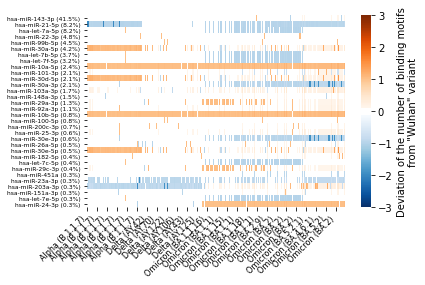

In [44]:
plot_df = count_df.loc[count_df["region"] == "RNA"].copy()

plot_df.index = plot_df["strain"]
plot_df = plot_df[MIMATS]
plot_df = plot_df.join(meta_df[["scorpio_call", "lineage", "length"]], how="left")

for mimat in MIMATS:
    plot_df[mimat] = np.array(plot_df[mimat], dtype=np.float64) * \
        (29903 / np.array(plot_df["length"], dtype=np.float64)) - \
        np.array(wcount_df[mimat], dtype=np.float64)

plot_df["strain"] = plot_df["scorpio_call"].str.split("(").str[0] + "(" + \
    plot_df["lineage"] + ")"
plot_df.index = plot_df["strain"]
plot_df = plot_df[MIMATS]

plot_df = plot_df.transpose()

miRNA_df.index = miRNA_df["MIMAT"]
plot_df = plot_df.join(miRNA_df[["miRNA", "CPM"]], how="left").sort_values(by="CPM", ascending=False)
plot_df.index = plot_df["miRNA"]
plot_df = plot_df.drop(columns=["miRNA", "CPM"])

plot_df["index"] = plot_df.index
miRNA_df.index = miRNA_df["miRNA"]
plot_df["index"] = plot_df["index"].apply(lambda x: f"{x} ({miRNA_df.loc[x]['CPM'] / miRNA_df['CPM'].sum() * 100:.1f}%)")
miRNA_df.index = miRNA_df["MIMAT"]
plot_df.index = plot_df["index"]
plot_df = plot_df.drop(columns=["index"])

bottom = mpl.colormaps['Oranges']
top = mpl.colormaps['Blues_r']
colors = np.vstack((
    top(np.linspace(0, 1, 128)),
    [[0, 0, 0, 0]] * 10,
    bottom(np.linspace(0, 1, 128))
))
cmap = ListedColormap(colors, name='OrangeBlue')

sns.heatmap(
    plot_df,
    cmap=cmap,
    vmin=-3,
    vmax=3,
    # linewidths=1,
    # linecolor="white",
    cbar_kws={
        "ticks": [-3, -2, -1, 0, 1, 2, 3],
        # "label": "Отклонение количества регионов\nсвязывания от Wuhan варианта"
        "label": 'Deviation of the number of binding motifs\nfrom "Wuhan" variant'
    }
)

plt.yticks(
    [0.5 + i for i in range(len(plot_df))],
    labels=plot_df.index.to_list(),
    fontsize=6
)
plt.ylabel("")

plt.xticks(
    fontsize=8,
    rotation=45,
    ha="right"
)

plt.tight_layout()
plt.savefig("../../pictures/berlin-miRNA-covid-luad-300.png", dpi=300)
plt.savefig("../../pictures/berlin-miRNA-covid-luad-300.tiff", dpi=300)

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 85.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 80.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


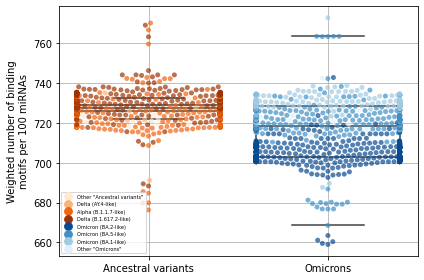

In [45]:
plot_df = count_df.loc[count_df["region"] == "RNA"].copy()
plot_df.index = plot_df["strain"]
plot_df = plot_df[["weighted count"]]

plot_df = plot_df.join(meta_df[["scorpio_call", "lineage", "group", "length"]], how="left")

plot_df.loc[
    (plot_df["group"] == "first") & \
    ~(plot_df["scorpio_call"].isin([
        "Delta (B.1.617.2-like)",
        "Alpha (B.1.1.7-like)",
        "Delta (AY.4-like)"
    ])), "scorpio_call"
] = 'Other "Ancestral variants"'

plot_df.loc[
    (plot_df["group"] == "second") & \
    ~(plot_df["scorpio_call"].isin([
        "Omicron (BA.2-like)",
        "Omicron (BA.5-like)",
        "Omicron (BA.1-like)"
    ])), "scorpio_call"
] = 'Other "Omicrons"'

plot_df.loc[plot_df["group"] == "first", "group"] = "Ancestral variants"
plot_df.loc[plot_df["group"] == "second", "group"] = "Omicrons"
plot_df = plot_df.rename(columns={
    "scorpio_call": "Strain"
})

plot_df["weighted count"] = plot_df["weighted count"] * 29903 / plot_df["length"] * 100

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    # bottom(np.linspace(0.1, 0.9, 11)),
    # top(np.linspace(0.1, 0.9, 8)),
    bottom(np.linspace(0.1, 0.9, 4)),
    top(np.linspace(0.1, 0.9, 4))
))
cmap = ListedColormap(colors, name='OrangeBlue')

ax = sns.swarmplot(
    y="weighted count",
    x="group",
    hue="Strain",
    hue_order=[
        'Other "Ancestral variants"',
        "Delta (AY.4-like)",
        "Alpha (B.1.1.7-like)",
        "Delta (B.1.617.2-like)",
        "Omicron (BA.2-like)",
        "Omicron (BA.5-like)",
        "Omicron (BA.1-like)",
        'Other "Omicrons"'
    ],
    alpha=0.7,
    data=plot_df,
    palette=cmap.colors,
)

ax = sns.boxplot(
    y="weighted count",
    x="group",
    data=plot_df,
    # palette=cmap.colors,
    boxprops={'facecolor': 'None'},
    whiskerprops={'linewidth': 0},
    showfliers=False,
    ax=ax
)

ax.set_xlabel("")
ax.set_ylabel("Weighted number of binding\nmotifs per 100 miRNAs")

# ax.set_yticks(
#     [6.8, 7.0, 7.2, 7.4, 7.6, 7.8],
#     [680, 700, 720, 740, 760, 780]
# )

# plt.xticks(
#     fontsize=8,
#     rotation=45,
#     ha="right"
# )

handles = ax.get_legend().legendHandles
handles = ax.get_legend().legendHandles
plt.legend(
    handles,
    [
        'Other "Ancestral variants"',
        "Delta (AY.4-like)",
        "Alpha (B.1.1.7-like)",
        "Delta (B.1.617.2-like)",
        "Omicron (BA.2-like)",
        "Omicron (BA.5-like)",
        "Omicron (BA.1-like)",
        'Other "Omicrons"'
    ],
    loc="lower left",
    prop={"size": 5}
)

plt.grid()
plt.tight_layout()
plt.savefig("../../pictures/berlin-covid-weighted-luad-300.png", dpi=300)
plt.savefig("../../pictures/berlin-covid-weighted-luad-300.tiff", dpi=300)

In [46]:
print(mannwhitneyu(
    plot_df.loc[plot_df["group"] == "Ancestral variants", "weighted count"].to_list(),
    plot_df.loc[plot_df["group"] == "Omicrons", "weighted count"].to_list(),
    # alternative="greater"
))

MannwhitneyuResult(statistic=2597471.0, pvalue=1.0711457154186192e-146)


In [47]:
import numpy as np
from scipy.stats import spearmanr

In [48]:
plot_df = count_df.loc[count_df["region"] == "RNA"].copy()
plot_df.index = plot_df["strain"]
plot_df = plot_df[["weighted count"]]

plot_df = plot_df.join(meta_df[[
    "scorpio_call", "lineage",
    "group", "length", "days"
]], how="left")


plot_df = plot_df.loc[
    plot_df["scorpio_call"] != "Omicron (BA.2-like)"
]

plot_df["weighted count"] = plot_df["weighted count"] * 29903 / plot_df["length"] * 100

spearmanr(
    plot_df["days"].to_list(),
    plot_df["weighted count"].to_list(),
    alternative="less"
)

SignificanceResult(statistic=-0.09958864340817934, pvalue=4.538194085693657e-08)

/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


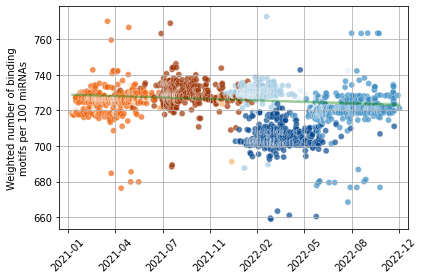

In [49]:
plot_df = count_df.loc[count_df["region"] == "RNA"].copy()
plot_df.index = plot_df["strain"]
plot_df = plot_df[["weighted count"]]

plot_df = plot_df.join(meta_df[[
    "scorpio_call", "lineage",
    "group", "length", "days", "date"
]], how="left")

plot_df.loc[
    (plot_df["group"] == "first") & \
    ~(plot_df["scorpio_call"].isin([
        "Delta (B.1.617.2-like)",
        "Alpha (B.1.1.7-like)",
        "Delta (AY.4-like)"
    ])), "scorpio_call"
] = 'Other "Ancestral variants"'

plot_df.loc[
    (plot_df["group"] == "second") & \
    ~(plot_df["scorpio_call"].isin([
        "Omicron (BA.2-like)",
        "Omicron (BA.5-like)",
        "Omicron (BA.1-like)"
    ])), "scorpio_call"
] = 'Other "Omicrons"'

# plot_df = plot_df.loc[
#     plot_df["scorpio_call"] != "Omicron (BA.2-like)"
# ]

plot_df.loc[plot_df["group"] == "first", "group"] = "Ancestral variants"
plot_df.loc[plot_df["group"] == "second", "group"] = "Omicrons"
plot_df = plot_df.rename(columns={
    "scorpio_call": "Strain"
})

plot_df["weighted count"] = plot_df["weighted count"] * 29903 / plot_df["length"] * 100

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    # bottom(np.linspace(0.1, 0.9, 11)),
    # top(np.linspace(0.1, 0.9, 8)),
    bottom(np.linspace(0.1, 0.9, 4)),
    top(np.linspace(0.1, 0.9, 4))
))
cmap = ListedColormap(colors, name='OrangeBlue')

ax = sns.scatterplot(
    x="days",
    y="weighted count",
    data=plot_df,
    hue="Strain",
    hue_order=[
        'Other "Ancestral variants"',
        "Delta (AY.4-like)",
        "Alpha (B.1.1.7-like)",
        "Delta (B.1.617.2-like)",
        "Omicron (BA.2-like)",
        "Omicron (BA.5-like)",
        "Omicron (BA.1-like)",
        'Other "Omicrons"'
    ],
    linewidth=0.3,
    alpha=0.7,
    palette=cmap.colors,
    legend=False
)

ax = sns.regplot(
    x=plot_df.loc[
        plot_df["Strain"] != "Omicron (BA.2-like)"
    ]["days"],
    y=plot_df.loc[
        plot_df["Strain"] != "Omicron (BA.2-like)"
    ]["weighted count"].astype(float),
    scatter=False,
    line_kws={
        'color': "green",
        'alpha': 0.3
    },
    order=1,
    ci=100,
    ax=ax
)

ax.set_xlim(left=350, right=1090)
ax.xaxis.set_ticks(list(range(370, 1170, 100)))
ax.xaxis.set_ticklabels(
    "-".join(str(date).split()[0].split("-")[:-1]) for date in [
        START + pd.DateOffset(days=d) for d in range(370, 1170, 100)
    ]
)

plt.xticks(rotation=45)
plt.xlabel("")
# ax.set_xlabel("Number of days since the pandemic start")
plt.ylabel("Weighted number of binding\nmotifs per 100 miRNAs")

plt.grid()
plt.tight_layout()
plt.savefig("../../pictures/berlin-covid-weighted-time-luad-300.png", dpi=300)
plt.savefig("../../pictures/berlin-covid-weighted-time-luad-300.tiff", dpi=300)